# Final Project - CIS731
### Kaitlyn Stick-Mueller
### Calculating Customer Lifetime Value

***

### Importing packages and data

In [2]:
# To use Spark and its API, import the package SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext

# Create a SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("MP5 - Obtaining and Loading Data using Python Spark SQL") \
    .getOrCreate()

from pyspark.sql.types import *

In [4]:
# importing dataset


# Define schema for data
schema = StructType([StructField('InvoiceNo', StringType(), True),
                    StructField('StockCode', StringType(), True),
                    StructField('Description', StringType(), True),
                     StructField('Quantity', IntegerType(), True),
                     StructField('InvoiceDate', StringType(), True),
                     StructField('UnitPrice', FloatType(), True),
                     StructField('CustomerID', StringType(), True),
                     StructField('Country', StringType(), True)
                    ])

# read csv file from google drive
from google.colab import drive
drive.mount('/content/drive')
filePath = "/content/drive/MyDrive/data/online_retail.csv"
df = spark.read.option("delimiter",",").option("header", True).csv(filePath, schema=schema)

# set InvoiceDate as date column
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
from pyspark.sql.functions import split, to_date

#updating InvoiceDate as date column
df = df.withColumn("date", split("InvoiceDate", " ")[0])
df = df.withColumn("InvoiceDate", to_date("date", "MM/dd/yyyy"))
df = df.drop('date')

# view first 20 rows of data
df.show()

Mounted at /content/drive
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6| 2010-12-01|     4.25| 

In [5]:
# determine size of df

print(df.count(), len(df.columns))

541909 8


In [6]:
# view as pandas dataframe
df.toPandas().head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom


### Data Cleaning

In [7]:
# create sales amount column
import pyspark.sql.functions as F

# sales = quantity * unit price

df = df.withColumn("Sales", F.round(df.Quantity * df.UnitPrice, 2))

df.show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom| 15.3|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom| 22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom| 15.3|
|   536365|    21730|GLASS STAR FROSTE...|    

In [8]:
# view daily transactions

df.createOrReplaceTempView("df")

daily_transactions = spark.sql("SELECT CustomerID, InvoiceDate, COUNT(DISTINCT InvoiceNo) as Transactions, SUM(Sales) as Sales FROM df GROUP BY CustomerID, InvoiceDate ORDER BY Sales DESC, CustomerID, InvoiceDate")
daily_transactions.show()

+----------+-----------+------------+------------------+
|CustomerID|InvoiceDate|Transactions|             Sales|
+----------+-----------+------------+------------------+
|     17450| 2011-09-20|           8| 71601.44078063965|
|      NULL| 2011-11-14|          18| 55316.08002990484|
|      NULL| 2011-11-07|          11|42939.170391619205|
|      NULL| 2011-03-29|          37| 33521.39997935295|
|      NULL| 2011-12-08|          12|  31975.5899861753|
|     18102| 2011-09-15|           5|31661.539978027344|
|      NULL| 2010-12-21|          30|31347.479961156845|
|     18102| 2011-10-21|           3|29693.820068359375|
|     18102| 2010-12-07|           3|25920.370086669922|
|     14646| 2011-10-20|           3| 25833.56004714966|
|      NULL| 2010-12-10|          13|25399.559899777174|
|      NULL| 2010-12-17|          12|25371.769902050495|
|      NULL| 2011-11-25|          20|24148.069934681058|
|      NULL| 2011-11-29|          14| 23744.25001564622|
|     12415| 2011-06-15|       

In [ ]:
# check for rows where customerID is null (don't know which customer placed these orders)

df.filter(df.CustomerID.isNull()).show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   536414|    22139|                NULL|      56| 2010-12-01|      0.0|      NULL|United Kingdom|  0.0|
|   536544|    21773|DECORATIVE ROSE B...|       1| 2010-12-01|     2.51|      NULL|United Kingdom| 2.51|
|   536544|    21774|DECORATIVE CATS B...|       2| 2010-12-01|     2.51|      NULL|United Kingdom| 5.02|
|   536544|    21786|  POLKADOT RAIN HAT |       4| 2010-12-01|     0.85|      NULL|United Kingdom|  3.4|
|   536544|    21787|RAIN PONCHO RETRO...|       2| 2010-12-01|     1.66|      NULL|United Kingdom| 3.32|
|   536544|    21790|  VINTAGE SNAP CARDS|       9| 2010-12-01|     1.66|      NULL|United Kingdom|14.94|
|   536544|    21791|VINTAGE HEADS AND...|    

In [14]:
# remove rows where customerid is null

df = df.filter(df.CustomerID.isNotNull())
df.show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom| 15.3|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom| 22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom| 15.3|
|   536365|    21730|GLASS STAR FROSTE...|    

In [9]:
# find rows where daily sales are very large (from daily transactions)

df.filter(df.CustomerID=="17450").show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|  Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-------+
|   537448|    21756|BATH BUILDING BLO...|       6| 2010-12-07|      6.6|     17450|United Kingdom|   39.6|
|   537456|    22469|HEART OF WICKER S...|     402| 2010-12-07|     1.93|     17450|United Kingdom| 775.86|
|   537456|    22470|HEART OF WICKER L...|     378| 2010-12-07|     3.21|     17450|United Kingdom|1213.38|
|   540689|    21733|RED HANGING HEART...|     860| 2011-01-11|     3.24|     17450|United Kingdom| 2786.4|
|   540689|   85123A|WHITE HANGING HEA...|    1010| 2011-01-11|     3.24|     17450|United Kingdom| 3272.4|
|   540689|    22469|HEART OF WICKER S...|    1356| 2011-01-11|     1.93|     17450|United Kingdom|2617.08|
|   540689|    22470|HEART O

In [15]:
# remove rows where sales are very large

df = df.filter(df.CustomerID!="17450")
df.show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom| 15.3|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom| 22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom| 15.3|
|   536365|    21730|GLASS STAR FROSTE...|    

In [16]:
# exclude data from December 2011 to make all data be for 1 year (Dec 1 2010 - Nov 30 2011)

df = df.filter(df.InvoiceDate < "2011-12-01")
df.orderBy(df.InvoiceDate.desc()).show(10)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|Sales|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+-----+
|   579522|    84879|ASSORTED COLOUR B...|       8| 2011-11-30|     1.69|     14432|United Kingdom|13.52|
|   579522|    23241|TREASURE TIN GYMK...|       6| 2011-11-30|     2.08|     14432|United Kingdom|12.48|
|   579522|    82486|3 DRAWER ANTIQUE ...|       4| 2011-11-30|     8.95|     14432|United Kingdom| 35.8|
|   579522|    82483|WOOD 2 DRAWER CAB...|       8| 2011-11-30|     6.95|     14432|United Kingdom| 55.6|
|   579522|    23493|VINTAGE DOILY TRA...|      10| 2011-11-30|     1.95|     14432|United Kingdom| 19.5|
|   579522|    23240|SET OF 4 KNICK KN...|       6| 2011-11-30|     4.15|     14432|United Kingdom| 24.9|
|   579522|    20724|RED RETROSPOT CHA...|    

### Exploratory Data Anaylsis

In [21]:
# recompute daily transactions after removed data
df.createOrReplaceTempView("df")

daily_transactions = spark.sql("SELECT CustomerID, InvoiceDate, COUNT(DISTINCT InvoiceNo) as Transactions, SUM(Sales) as Sales FROM df GROUP BY CustomerID, InvoiceDate ORDER BY CustomerID, InvoiceDate")
daily_transactions_pd = daily_transactions.toPandas()

In [22]:
# Histogram of Daily Sales

import plotly.express as px
fig = px.histogram(daily_transactions_pd, x="InvoiceDate", y="Sales")
fig.show()

In [23]:
# monthly transactions

df.createOrReplaceTempView("df")

monthly = spark.sql("SELECT TRUNC(InvoiceDate, 'month') as InvoiceMonth, COUNT(DISTINCT InvoiceNo) as Transactions, SUM(Sales) as Sales FROM df GROUP BY InvoiceMonth ORDER BY InvoiceMonth")
monthly.show()

+------------+------------+------------------+
|InvoiceMonth|Transactions|             Sales|
+------------+------------+------------------+
|  2010-12-01|        1706| 552575.1805045903|
|  2011-01-01|        1233| 456454.1798314601|
|  2011-02-01|        1201|437678.23018600047|
|  2011-03-01|        1616| 566464.1099586785|
|  2011-04-01|        1381|422488.54968772084|
|  2011-05-01|        1845| 630225.3987072557|
|  2011-06-01|        1705| 603153.2587205693|
|  2011-07-01|        1590| 565753.3388745934|
|  2011-08-01|        1539| 600415.6185245588|
|  2011-09-01|        2063| 861193.8686770275|
|  2011-10-01|        2261|  970667.628561154|
|  2011-11-01|        3075| 1104570.288091246|
+------------+------------+------------------+



In [24]:
# create pd dataframe from monthly sales and plot as line graph

monthly_pd = monthly.toPandas()

fig = px.line(monthly_pd, x="InvoiceMonth", y="Sales", line_shape="spline", markers="True")
fig.show()

In [25]:
# monthly transactions colored by sales amount
fig = px.bar(monthly_pd, x="InvoiceMonth", y="Transactions", color="Sales")
fig.show()

In [26]:
# view monthly numbers

monthly_pd

,InvoiceMonth,Transactions,Sales
0,2010-12-01,1706,5.525752e+05
1,2011-01-01,1233,4.564542e+05
2,2011-02-01,1201,4.376782e+05
3,2011-03-01,1616,5.664641e+05
4,2011-04-01,1381,4.224885e+05
5,2011-05-01,1845,6.302254e+05
6,2011-06-01,1705,6.031533e+05
7,2011-07-01,1590,5.657533e+05
8,2011-08-01,1539,6.004156e+05
9,2011-09-01,2063,8.611939e+05


In [ ]:
# unique customers, transactions, and total sales

df.createOrReplaceTempView("df")

customer_insights = spark.sql("SELECT COUNT(DISTINCT CustomerID) as Customers, COUNT(DISTINCT InvoiceNo) as Transactions, SUM(Sales) as Sales FROM df")
customer_insights.show()

+---------+------------+-----------------+
|Customers|Transactions|            Sales|
+---------+------------+-----------------+
|     4330|       21215|7771639.650324855|
+---------+------------+-----------------+



### Calculate Metrics for Analysis: Recency, Frequency, Monetary Value

In [31]:
# calculating metrics

# recency, frequency, monetary value (RFM for CLV)

# we will want a fresh dataframe that we will add various metrics for each customerID - therefore we will know RFM values for each customer ID number

dfCustomers = spark.sql("SELECT DISTINCT CustomerID as CustomerID FROM df")
dfCustomers.show()

+----------+
|CustomerID|
+----------+
|     16250|
|     15574|
|     15555|
|     15271|
|     17714|
|     17686|
|     13865|
|     14157|
|     13610|
|     13772|
|     13282|
|     12394|
|     16320|
|     13192|
|     17757|
|     17551|
|     13187|
|     16549|
|     12637|
|     15052|
+----------+
only showing top 20 rows



In [32]:
# calculate recency: time since last purchase
#current date (11/30/2011) - last purchase date per CustomerID
from pyspark.sql.functions import max, datediff, lit

dfLastPurchase = df.groupBy("CustomerID").agg(max("InvoiceDate").alias("Last_Purchase"))

current_date = dfLastPurchase.agg(max("Last_Purchase").alias("current_date")).collect()[0]["current_date"]

dfLastPurchase = dfLastPurchase.withColumn("Current_Date", lit(current_date))

dfLastPurchase = dfLastPurchase.withColumn("Customer", dfLastPurchase.CustomerID)

dfLastPurchase = dfLastPurchase.select(
      "Customer",
      "Last_Purchase",
      datediff("Current_Date","Last_Purchase").alias("Recency")
    )
dfLastPurchase.show()

+--------+-------------+-------+
|Customer|Last_Purchase|Recency|
+--------+-------------+-------+
|   16250|   2011-03-23|    252|
|   15574|   2011-06-15|    168|
|   15555|   2011-11-27|      3|
|   15271|   2011-11-13|     17|
|   17714|   2011-01-23|    311|
|   17686|   2011-09-20|     71|
|   13865|   2011-10-12|     49|
|   14157|   2011-11-20|     10|
|   13610|   2011-11-27|      3|
|   13772|   2011-11-06|     24|
|   13282|   2011-11-21|      9|
|   12394|   2011-10-07|     54|
|   16320|   2011-06-20|    163|
|   13192|   2011-09-05|     86|
|   17757|   2011-11-25|      5|
|   17551|   2010-12-15|    350|
|   13187|   2011-01-06|    328|
|   16549|   2011-11-29|      1|
|   12637|   2011-10-03|     58|
|   15052|   2011-01-24|    310|
+--------+-------------+-------+
only showing top 20 rows



In [33]:
# join recency data to dfCustomers data

dfCustomers = dfCustomers.join(dfLastPurchase[['Customer','Recency']],dfCustomers.CustomerID ==  dfLastPurchase.Customer,"inner").drop("Customer")
dfCustomers.show()

+----------+-------+
|CustomerID|Recency|
+----------+-------+
|     16250|    252|
|     15574|    168|
|     15555|      3|
|     15271|     17|
|     17714|    311|
|     17686|     71|
|     13865|     49|
|     14157|     10|
|     13610|      3|
|     13772|     24|
|     13282|      9|
|     12394|     54|
|     16320|    163|
|     13192|     86|
|     17757|      5|
|     17551|    350|
|     13187|    328|
|     16549|      1|
|     12637|     58|
|     15052|    310|
+----------+-------+
only showing top 20 rows



In [34]:
from pyspark.sql.functions import countDistinct

# calculate frequency: number of purchases
dfFrequency = df.groupBy("CustomerID").agg(countDistinct("InvoiceNo").alias("Frequency"))

dfFrequency = dfFrequency.withColumn("Customer", dfFrequency.CustomerID)

dfFrequency = dfFrequency.select(
      "Customer",
      "Frequency"
    )
dfFrequency.show()

+--------+---------+
|Customer|Frequency|
+--------+---------+
|   15555|       20|
|   15574|        4|
|   14157|        3|
|   17686|        6|
|   13610|        9|
|   13865|        4|
|   16250|        2|
|   17714|        1|
|   13282|        6|
|   15271|       15|
|   16320|        2|
|   12394|        2|
|   13192|        2|
|   15634|        1|
|   17427|        1|
|   17506|        2|
|   18130|        3|
|   15269|        1|
|   16504|        1|
|   12847|        1|
+--------+---------+
only showing top 20 rows



In [35]:
# join frequency data to dfCustomers data

dfCustomers = dfCustomers.join(dfFrequency,dfCustomers.CustomerID ==  dfFrequency.Customer,"inner").drop("Customer")
dfCustomers.show()

+----------+-------+---------+
|CustomerID|Recency|Frequency|
+----------+-------+---------+
|     16250|    252|        2|
|     15574|    168|        4|
|     15555|      3|       20|
|     15271|     17|       15|
|     17714|    311|        1|
|     17686|     71|        6|
|     13865|     49|        4|
|     14157|     10|        3|
|     13610|      3|        9|
|     13772|     24|        3|
|     13282|      9|        6|
|     12394|     54|        2|
|     16320|    163|        2|
|     13192|     86|        2|
|     17757|      5|       29|
|     17551|    350|        1|
|     13187|    328|        1|
|     16549|      1|       10|
|     12637|     58|       10|
|     15052|    310|        1|
+----------+-------+---------+
only showing top 20 rows



In [36]:
# calculate monetary value: how much each customer spends
from pyspark.sql.functions import sum
dfMonetaryValue = df.groupBy("CustomerID").agg(sum("Sales").alias("Monetary_Value"))

dfMonetaryValue = dfMonetaryValue.withColumn("Customer", dfMonetaryValue.CustomerID)

dfMonetaryValue = dfMonetaryValue.select(
      "Customer",
      "Monetary_Value"
    )
dfMonetaryValue.show()

+--------+------------------+
|Customer|    Monetary_Value|
+--------+------------------+
|   16250| 389.4400005340576|
|   15574|  702.249996304512|
|   15555|4758.1999671682715|
|   15271|2293.7399877905846|
|   17714|153.00000095367432|
|   17686| 5110.089953422546|
|   13865| 501.5600018501282|
|   14157| 400.4299980401993|
|   13610|1115.4299939274788|
|   13772| 1132.129998922348|
|   13282| 1047.840008020401|
|   12394|1272.4799976348877|
|   16320| 1038.459997177124|
|   13192| 911.9400072097778|
|   17757| 5168.939989626408|
|   17551| 306.8399975299835|
|   13187|236.01999855041504|
|   16549| 4154.639976412058|
|   12637| 5953.249971777201|
|   15052|215.78000164031982|
+--------+------------------+
only showing top 20 rows



In [37]:
# merge dfMonetaryValue with dfCustomers

dfCustomers = dfCustomers.join(dfMonetaryValue,dfCustomers.CustomerID ==  dfMonetaryValue.Customer,"inner").drop("Customer")
dfCustomers.show()

+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|    Monetary_Value|
+----------+-------+---------+------------------+
|     16250|    252|        2| 389.4400005340576|
|     15574|    168|        4|  702.249996304512|
|     15555|      3|       20|4758.1999671682715|
|     15271|     17|       15|2293.7399877905846|
|     17714|    311|        1|153.00000095367432|
|     17686|     71|        6| 5110.089953422546|
|     13865|     49|        4| 501.5600018501282|
|     14157|     10|        3| 400.4299980401993|
|     13610|      3|        9|1115.4299939274788|
|     13772|     24|        3| 1132.129998922348|
|     13282|      9|        6| 1047.840008020401|
|     12394|     54|        2|1272.4799976348877|
|     16320|    163|        2| 1038.459997177124|
|     13192|     86|        2| 911.9400072097778|
|     17757|      5|       29| 5168.939989626408|
|     17551|    350|        1| 306.8399975299835|
|     13187|    328|        1|236.01999855041504|


In [38]:
# more cleaning:

# remove customers who spend negative dollars

dfCustomers = dfCustomers.filter(dfCustomers.Monetary_Value > 0)

dfCustomers.show()

+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|    Monetary_Value|
+----------+-------+---------+------------------+
|     16250|    252|        2| 389.4400005340576|
|     15574|    168|        4|  702.249996304512|
|     15555|      3|       20|4758.1999671682715|
|     15271|     17|       15|2293.7399877905846|
|     17714|    311|        1|153.00000095367432|
|     17686|     71|        6| 5110.089953422546|
|     13865|     49|        4| 501.5600018501282|
|     14157|     10|        3| 400.4299980401993|
|     13610|      3|        9|1115.4299939274788|
|     13772|     24|        3| 1132.129998922348|
|     13282|      9|        6| 1047.840008020401|
|     12394|     54|        2|1272.4799976348877|
|     16320|    163|        2| 1038.459997177124|
|     13192|     86|        2| 911.9400072097778|
|     17757|      5|       29| 5168.939989626408|
|     17551|    350|        1| 306.8399975299835|
|     13187|    328|        1|236.01999855041504|


In [39]:
# determine how many customers we have to analyze

print(dfCustomers.count())

4276


### Model Building using our vales for recency, frequency, and monetary value

In [40]:
# normalize data using MinMaxScaler

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["Recency","Frequency","Monetary_Value"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    dfCustomers = pipeline.fit(dfCustomers).transform(dfCustomers).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
dfCustomers.show(5)

After Scaling :
+----------+-------+---------+------------------+--------------+----------------+---------------------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|
+----------+-------+---------+------------------+--------------+----------------+---------------------+
|     16250|    252|        2| 389.4400005340576|         0.692|           0.004|                0.001|
|     15574|    168|        4|  702.249996304512|         0.462|           0.013|                0.003|
|     15555|      3|       20|4758.1999671682715|         0.008|            0.08|                0.018|
|     15271|     17|       15|2293.7399877905846|         0.047|           0.059|                0.009|
|     17714|    311|        1|153.00000095367432|         0.854|             0.0|                0.001|
+----------+-------+---------+------------------+--------------+----------------+---------------------+
only showing top 5 rows



In [41]:
# view dfCustomers as pandas dataframe

dfCustomers.toPandas()

,CustomerID,Recency,Frequency,Monetary_Value,Recency_Scaled,Frequency_Scaled,Monetary_Value_Scaled
0,16250,252,2,389.440001,0.692,0.004,0.001
1,15574,168,4,702.249996,0.462,0.013,0.003
2,15555,3,20,4758.199967,0.008,0.080,0.018
3,15271,17,15,2293.739988,0.047,0.059,0.009
4,17714,311,1,153.000001,0.854,0.000,0.001
...,...,...,...,...,...,...,...
4271,13878,45,1,1281.530011,0.124,0.000,0.005
4272,16363,44,1,109.360002,0.121,0.000,0.000
4273,17081,16,2,290.159996,0.044,0.004,0.001
4274,15345,26,2,367.689998,0.071,0.004,0.001


In [42]:
# assemble a vector of our scaled features for use in ml models

vecAssembler = VectorAssembler(inputCols=["Recency_Scaled", "Frequency_Scaled","Monetary_Value_Scaled"], outputCol="features")
new_df = vecAssembler.transform(dfCustomers)
new_df.show()

+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+
|     16250|    252|        2| 389.4400005340576|         0.692|           0.004|                0.001|[0.692,0.004,0.001]|
|     15574|    168|        4|  702.249996304512|         0.462|           0.013|                0.003|[0.462,0.013,0.003]|
|     15555|      3|       20|4758.1999671682715|         0.008|            0.08|                0.018| [0.008,0.08,0.018]|
|     15271|     17|       15|2293.7399877905846|         0.047|           0.059|                0.009|[0.047,0.059,0.009]|
|     17714|    311|        1|153.00000095367432|         0.854|             0.0|                0.001|  [0.854,0.0,0.001]|
|     17

In [43]:
# split data into training and testing data

train, test = new_df.randomSplit([0.7, 0.3], seed=1)

In [44]:
# determine length of each train and test set

print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

(2982, 8)
(1294, 8)


In [45]:
# Apply KMeans model

import time
start_time = time.time()

import pyspark.ml.clustering as clus
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#apply model
kmeans = clus.KMeans(k = 2, featuresCol='features')
model_kmeans = kmeans.fit(train.select('features'))

test_kmeans_use = model_kmeans.transform(test)

print(f"Execution time: {time.time() - start_time}")

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette0_kmeans = evaluator.evaluate(test_kmeans_use)
print("Silhouette with squared euclidean distance = " + str(silhouette0_kmeans), "for k =", 2)



test_kmeans_use.groupBy("prediction").agg({'*': 'count', 'Recency': 'avg', 'Frequency': 'avg', 'Monetary_Value': 'avg'}).show()




Execution time: 55.28585863113403
Silhouette with squared euclidean distance = 0.858473968588581 for k = 2
+----------+------------------+-------------------+------------------+--------+
|prediction|      avg(Recency)|avg(Monetary_Value)|    avg(Frequency)|count(1)|
+----------+------------------+-------------------+------------------+--------+
|         1| 39.97633744855967| 1879.0601722352023| 5.830246913580247|     972|
|         0|233.95652173913044| 477.36506172551873|1.8509316770186335|     322|
+----------+------------------+-------------------+------------------+--------+



In [47]:
# Apply BKM model to test data
import time
start_time = time.time()

from pyspark.ml.clustering import BisectingKMeans

#apply model
bkm = clus.BisectingKMeans(k = 2, featuresCol='features')
model_bkm = bkm.fit(train)

test_bkm_use = model_bkm.transform(test)

print(f"Execution time: {time.time() - start_time}")

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette0_bkm = evaluator.evaluate(test_bkm_use)
print("Silhouette with squared euclidean distance = " + str(silhouette0_bkm), "for k =", 2)


test_bkm_use.groupBy("prediction").agg({'*': 'count', 'Recency': 'avg', 'Frequency': 'avg', 'Monetary_Value': 'avg'}).show()



Execution time: 29.92879629135132
Silhouette with squared euclidean distance = 0.858473968588581 for k = 2
+----------+------------------+-------------------+------------------+--------+
|prediction|      avg(Recency)|avg(Monetary_Value)|    avg(Frequency)|count(1)|
+----------+------------------+-------------------+------------------+--------+
|         1|233.95652173913044| 477.36506172551873|1.8509316770186335|     322|
|         0| 39.97633744855967| 1879.0601722352023| 5.830246913580247|     972|
+----------+------------------+-------------------+------------------+--------+



In [48]:
# view test data with its prediction

test_kmeans_use.show()

+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+----------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|prediction|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+----------+
|     12352|     27|       11| 1545.409993171692|         0.074|           0.042|                0.006|[0.074,0.042,0.006]|         1|
|     12353|    195|        1|              89.0|         0.536|             0.0|                  0.0|    [0.536,0.0,0.0]|         0|
|     12361|    278|        1|189.89999961853027|         0.764|             0.0|                0.001|  [0.764,0.0,0.001]|         0|
|     12362|      2|       12| 4625.540004968643|         0.005|           0.046|                0.017|[0.005,0.046,0.017]|         1|
|     12363|    100|        2| 551.9999961853027|      

In [49]:
# Rename prediction column to cluster

test_kmeans_use = test_kmeans_use.withColumnRenamed('prediction', 'cluster')
test_kmeans_use.show(5)

+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|cluster|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+
|     12352|     27|       11| 1545.409993171692|         0.074|           0.042|                0.006|[0.074,0.042,0.006]|      1|
|     12353|    195|        1|              89.0|         0.536|             0.0|                  0.0|    [0.536,0.0,0.0]|      0|
|     12361|    278|        1|189.89999961853027|         0.764|             0.0|                0.001|  [0.764,0.0,0.001]|      0|
|     12362|      2|       12| 4625.540004968643|         0.005|           0.046|                0.017|[0.005,0.046,0.017]|      1|
|     12363|    100|        2| 551.9999961853027|         0.275|           0

In [50]:
# make a new features vector of original RFM factors

vecAssembler = VectorAssembler(inputCols=["Recency", "Frequency","Monetary_Value"], outputCol="featuresRFM")
test_kmeans_use2 = vecAssembler.transform(test_kmeans_use)
test_kmeans_use2.show()

+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|cluster|         featuresRFM|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+
|     12352|     27|       11| 1545.409993171692|         0.074|           0.042|                0.006|[0.074,0.042,0.006]|      1|[27.0,11.0,1545.4...|
|     12353|    195|        1|              89.0|         0.536|             0.0|                  0.0|    [0.536,0.0,0.0]|      0|    [195.0,1.0,89.0]|
|     12361|    278|        1|189.89999961853027|         0.764|             0.0|                0.001|  [0.764,0.0,0.001]|      0|[278.0,1.0,189.89...|
|     12362|      2|       12| 4625.540004968643|         0.005|           0.046| 

In [51]:
# resplit data from test data with clusters
train_class, test_class = test_kmeans_use2.randomSplit([0.7, 0.3], seed=1)

In [52]:
# determine number of customers in each group, and how many invaluable customers per group
print((train_class.count(), train_class.filter(train_class.cluster == 0).count()))
print((test_class.count(), test_class.filter(test_class.cluster == 0).count()))

(926, 235)
(368, 87)


In [53]:
# apply logistic regression classifier
from pyspark.ml.classification import LogisticRegression

import time
start_time = time.time()



lr = LogisticRegression(featuresCol='featuresRFM', labelCol='cluster')

# Fit the model
lrModel = lr.fit(train_class)

predictionslr = lrModel.transform(test_class)

print(f"Execution time: {time.time() - start_time}")

predictionslr.show()

Execution time: 49.135664224624634
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+--------------------+--------------------+----------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|cluster|         featuresRFM|       rawPrediction|         probability|prediction|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+--------------------+--------------------+----------+
|     12363|    100|        2| 551.9999961853027|         0.275|           0.004|                0.002|[0.275,0.004,0.002]|      1|[100.0,2.0,551.99...|[-351.12969013921...|[3.20858198034690...|       1.0|
|     12364|     31|        3|1002.7799968719482|         0.085|           0.008|                0.004|[0.085,0.008,0.004]|      1|[31.0,3.0,

In [54]:
# evaluate logistic regression classifer

tp = predictionslr.filter((predictionslr.cluster == 1) & (predictionslr.prediction == 1)).count()
tn = predictionslr.filter((predictionslr.cluster == 0) & (predictionslr.prediction == 0)).count()
fp = predictionslr.filter((predictionslr.cluster == 0) & (predictionslr.prediction == 1)).count()
fn = predictionslr.filter((predictionslr.cluster == 1) & (predictionslr.prediction == 0)).count()


# precision, recall, f1-score
precision = tp / (tp+fp) if (tp +fp) > 0 else 0.0
recall = tp / (tp+fn) if (tp+fn) > 0 else 0.0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
support_1 = tp + fn
support_0 = tn + fp

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Support (1): {support_1}")
print(f"Support (0): {support_0}")

Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Support (1): 281
Support (0): 87


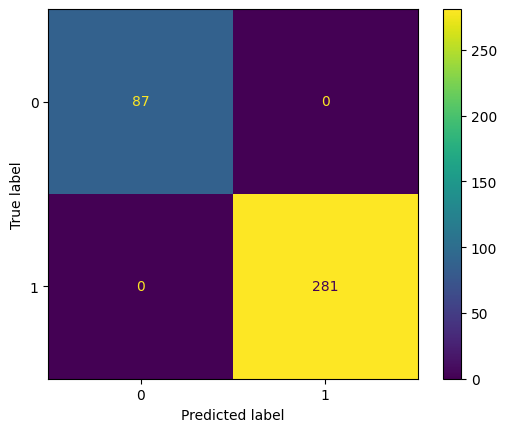

In [55]:
# confusion matrix for logistic regression
import matplotlib.pyplot as plt
from sklearn import metrics


predictionslr_pd = predictionslr.toPandas()

confusion_matrix = metrics.confusion_matrix(predictionslr_pd['cluster'], predictionslr_pd['prediction'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [56]:
# test random forest classifier


from pyspark.ml.classification import RandomForestClassifier

import time
start_time = time.time()


rfc = RandomForestClassifier(featuresCol='featuresRFM', labelCol='cluster')

# Fit the model
rfcModel = rfc.fit(train_class)

predictionsrfc = rfcModel.transform(test_class)

print(f"Execution time: {time.time() - start_time}")

predictionsrfc.show()

Execution time: 47.08729362487793
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+--------------------+--------------------+----------+
|CustomerID|Recency|Frequency|    Monetary_Value|Recency_Scaled|Frequency_Scaled|Monetary_Value_Scaled|           features|cluster|         featuresRFM|       rawPrediction|         probability|prediction|
+----------+-------+---------+------------------+--------------+----------------+---------------------+-------------------+-------+--------------------+--------------------+--------------------+----------+
|     12363|    100|        2| 551.9999961853027|         0.275|           0.004|                0.002|[0.275,0.004,0.002]|      1|[100.0,2.0,551.99...|[0.00921037363657...|[4.60518681828730...|       1.0|
|     12364|     31|        3|1002.7799968719482|         0.085|           0.008|                0.004|[0.085,0.008,0.004]|      1|[31.0,3.0,1

In [57]:
# evaluate random forest classifer

tp = predictionsrfc.filter((predictionsrfc.cluster == 1) & (predictionsrfc.prediction == 1)).count()
tn = predictionsrfc.filter((predictionsrfc.cluster == 0) & (predictionsrfc.prediction == 0)).count()
fp = predictionsrfc.filter((predictionsrfc.cluster == 0) & (predictionsrfc.prediction == 1)).count()
fn = predictionsrfc.filter((predictionsrfc.cluster == 1) & (predictionsrfc.prediction == 0)).count()


# precision, recall, f1-score
precision = tp / (tp+fp) if (tp +fp) > 0 else 0.0
recall = tp / (tp+fn) if (tp+fn) > 0 else 0.0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
support_1 = tp + fn
support_0 = tn + fp

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Support (1): {support_1}")
print(f"Support (0): {support_0}")

Precision: 0.99
Recall: 1.00
F1-Score: 1.00
Support (1): 281
Support (0): 87


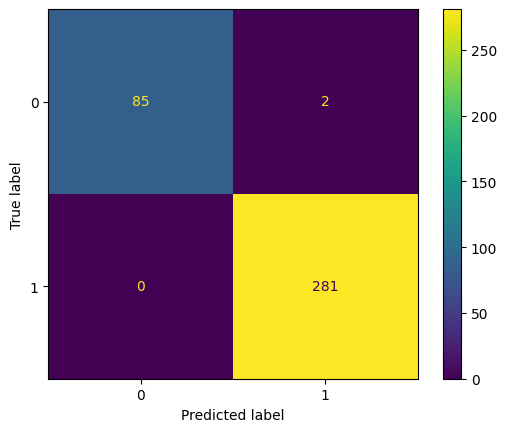

In [58]:
# confusion matrix for random forest classifier
predictionsrfc_pd = predictionsrfc.toPandas()

confusion_matrix = metrics.confusion_matrix(predictionsrfc_pd['cluster'], predictionsrfc_pd['prediction'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

### Review findings for insights on best customers

In [59]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-9.322661702005421,5.777655595800363,-0.017448645471473123]
Intercept: 1281.4722013818516


In [60]:
# review clustering data for analysis

kmeans_test_pd = test_kmeans_use2.toPandas()
kmeans_test_pd.head()

,CustomerID,Recency,Frequency,Monetary_Value,Recency_Scaled,Frequency_Scaled,Monetary_Value_Scaled,features,cluster,featuresRFM
0,12352,27,11,1545.409993,0.074,0.042,0.006,"[0.074, 0.042, 0.006]",1,"[27.0, 11.0, 1545.409993171692]"
1,12353,195,1,89.000000,0.536,0.000,0.000,"[0.536, 0.0, 0.0]",0,"[195.0, 1.0, 89.0]"
2,12361,278,1,189.900000,0.764,0.000,0.001,"[0.764, 0.0, 0.001]",0,"[278.0, 1.0, 189.89999961853027]"
3,12362,2,12,4625.540005,0.005,0.046,0.017,"[0.005, 0.046, 0.017]",1,"[2.0, 12.0, 4625.540004968643]"
4,12363,100,2,551.999996,0.275,0.004,0.002,"[0.275, 0.004, 0.002]",1,"[100.0, 2.0, 551.9999961853027]"


In [61]:
# plot average RFM values per cluster

kmeans_test_pd = kmeans_test_pd.replace({'cluster': 0}, {'cluster': '0: Less Valuable Customers'})
kmeans_test_pd = kmeans_test_pd.replace({'cluster': 1}, {'cluster': '1: More Valuable Customers'})


kmeans_test_avgs = kmeans_test_pd.groupby('cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary_Value': 'mean'}).reset_index()
kmeans_test_avgs.head()
fig = px.bar(kmeans_test_avgs, x="cluster", y=['Recency','Frequency','Monetary_Value'], title="Average RFM Values per Cluster",labels=dict(prediction="Cluster Group"), text_auto=True, width=800, height=500)
fig.update_layout(barmode='group')
fig.show()

In [62]:
# 3D plot of scatters for RFM
fig = px.scatter_3d(kmeans_test_pd, x='Recency', y='Frequency', z='Monetary_Value',
              color='cluster', width=800, height=700)
fig.show()

In [63]:
# profiles per cluster
kmeans_test_avgs.head()

,cluster,Recency,Frequency,Monetary_Value
0,0: Less Valuable Customers,233.956522,1.850932,477.365062
1,1: More Valuable Customers,39.976337,5.830247,1879.060172


In [64]:
# number of people in each cluster

kmeans_test_pd['cluster'].value_counts()

,count
cluster,
1: More Valuable Customers,972
0: Less Valuable Customers,322
